In [24]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
import imageio
import pathlib
import cv2 as cv
from PIL import Image
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import os
from skimage.io import imread
from skimage.transform import resize
import random
%matplotlib inline

# Get the images and the labels

In [2]:
IMG_HEIGHT = 400   # Define the constant for image height that will be used for the network
IMG_WIDTH = 600    # Define the constant for image width that will be used for the network
# Define all of the paths to the images here
PATH_TO_TRAIN = '../data/Training_Set/Training_Set/Training'
PATH_TO_VAL = '../data/Evaluation_Set/Evaluation_Set/Validation'
PATH_TO_TEST = '../data/Test_Set/Test_Set/Test'

# Define the function that will take in a directory of images and load them into a list and return them
def getData(directory):
    
    count = 0
    data = list()  # Python list to store the data in
    
    # Go through each file in the directory
    for i in range(len(os.listdir(directory))):
        
        file_name = '{0}.png'.format(i+1)
        img_path = os.path.join(directory, file_name)      # Get the path for the image file
        img = imread(img_path)                             # Open the image and make it into a numpy array
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH, 3))      # Resize the image based on the height and width defined above

        data.append(img)                                   # Append the image to the array
        
        count += 1
        if (count % 50) == 0:
            progress = (count / len(os.listdir(directory))) * 100
            data_name = directory.split('/')[-1]
            print("{:.2f}% completed loading {} data".format(progress, data_name))
        
    return data

In [3]:
# Get all of the paths for the images in the data folder
training_data = np.array(getData(PATH_TO_TRAIN))
validation_data = np.array(getData(PATH_TO_VAL))
testing_data = np.array(getData(PATH_TO_TEST))

# Load in the labels data into pandas DF
training_labels = pd.read_csv('../data/Training_Set/Training_Set/RFMiD_Training_Labels.csv')
validation_labels = pd.read_csv('../data/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')
test_labels = pd.read_csv('../data/Test_Set/Test_Set/RFMiD_Testing_labels.csv')

print("Complete")

2.60% completed loading Training data
5.21% completed loading Training data
7.81% completed loading Training data
10.42% completed loading Training data
13.02% completed loading Training data
15.62% completed loading Training data
18.23% completed loading Training data
20.83% completed loading Training data
23.44% completed loading Training data
26.04% completed loading Training data
28.65% completed loading Training data
31.25% completed loading Training data
33.85% completed loading Training data
36.46% completed loading Training data
39.06% completed loading Training data
41.67% completed loading Training data
44.27% completed loading Training data
46.88% completed loading Training data
49.48% completed loading Training data
52.08% completed loading Training data
54.69% completed loading Training data
57.29% completed loading Training data
59.90% completed loading Training data
62.50% completed loading Training data
65.10% completed loading Training data
67.71% completed loading Tra

In [29]:
# Make the labels only the binary disease columns
training_labels = training_labels.Disease_Risk.values
validation_labels = validation_labels.Disease_Risk.values
test_labels = test_labels.Disease_Risk.values

AttributeError: 'Series' object has no attribute 'Disease_Risk'

In [33]:
training_labels.values

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

# View random images from the training data

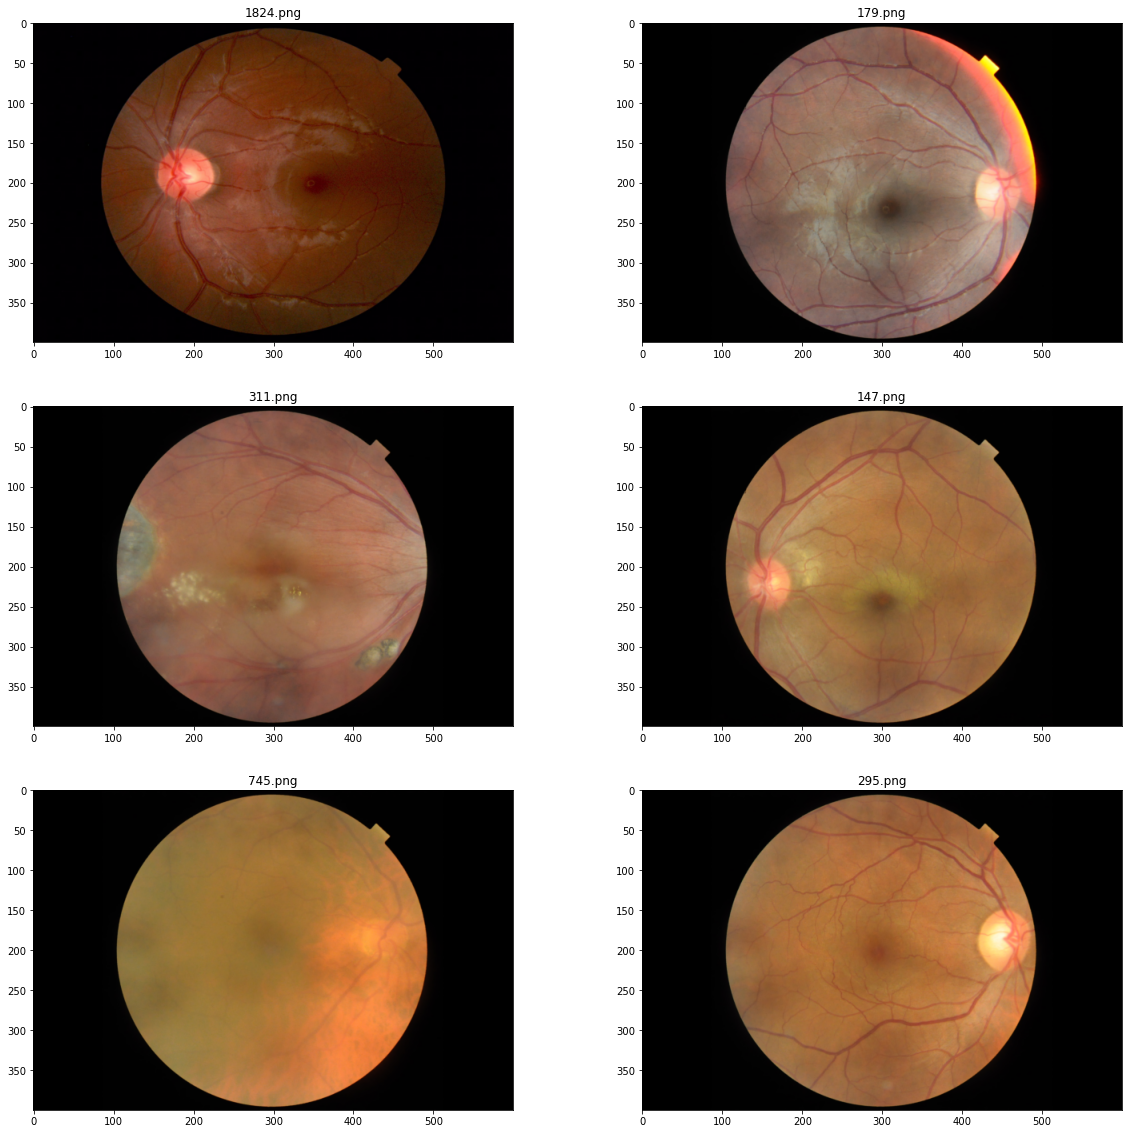

In [5]:
# Use the training location to print a few photos for reference
training_loc = PATH_TO_TRAIN + '/{0}.png'

plt.figure(figsize=(20,20))

for i in range(6):
    pos = random.randint(0, len(training_data))
    img = training_data[pos]
    title = "{0}.png".format(pos+1)
    ax = plt.subplot(3, 2, i+1)
    ax.title.set_text(title)
    plt.imshow(img)

# Run simple checks on the data before creating model

In [6]:
training_labels.shape[0] == training_data.shape[0]

True

In [7]:
validation_data.shape[0] == validation_labels.shape[0]

True

In [8]:
testing_data.shape[0] == test_labels.shape[0]

True

In [17]:
training_labels.Disease_Risk.value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

In [20]:
# Probability given the majority class
training_labels.Disease_Risk.value_counts()[1] / training_labels.Disease_Risk.value_counts().sum()

0.7911458333333333

In [ ]:
def create_model():
    '''Used to create a CNN model based on the RFMiD Dataset'''
    
    # Instantiate the model
    model = Sequential()
    